In [1]:
import numpy as np
from jax import vmap
import matplotlib.pyplot as plt

from distributions import Gaussian
from discrepancies import FisherDivergence

In [2]:
np.random.seed(0)

# Score Functions

We introduce the concept of the score function $\psi_p(x; \theta)$ for a probability distribution $p(x; \theta)$:

$$\psi_p(x; \theta) = \nabla_x \log p(x; \theta)$$

a mapping $\mathbb{R}^d \rightarrow \mathbb{R}^d$.

However, assuming $p(x; \theta)$ is of the form:

$$p(x; \theta) = \frac{1}{z(\theta)}\tilde{p}(x; \theta)$$

For convenience, we can redefine:

$$\psi_p(x; \theta) = \nabla_x \log \tilde{p}(x; \theta)$$


Similarly, if we have a set of observed data $\mathcal{D}$ such that 
$$\mathcal{D} = \{x_i \sim \mathbb{Q}\}$$
where $i = 1,2,...,n$

We can write the score function of $q(x)$, the distribution of $\mathcal{D}$ as:

$$\psi_q(x) = \nabla_x \log q(x)$$


## Gaussian

For Gaussian distributions, we know:

$$p(x) = p(x; \mu, \Sigma) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}} \exp(-\frac{1}{2}(x-\mu)^T \Sigma^{-1}(x-\mu))$$

where 

$$\tilde{p}(x) =\exp(-\frac{1}{2}(x-\mu)^T \Sigma^{-1}(x-\mu)) $$

and

$$\nabla_x \log \tilde{p}(x) =  -\Sigma^{-1} (x-\mu)$$

We can visualise this for a few Gaussian distributions:

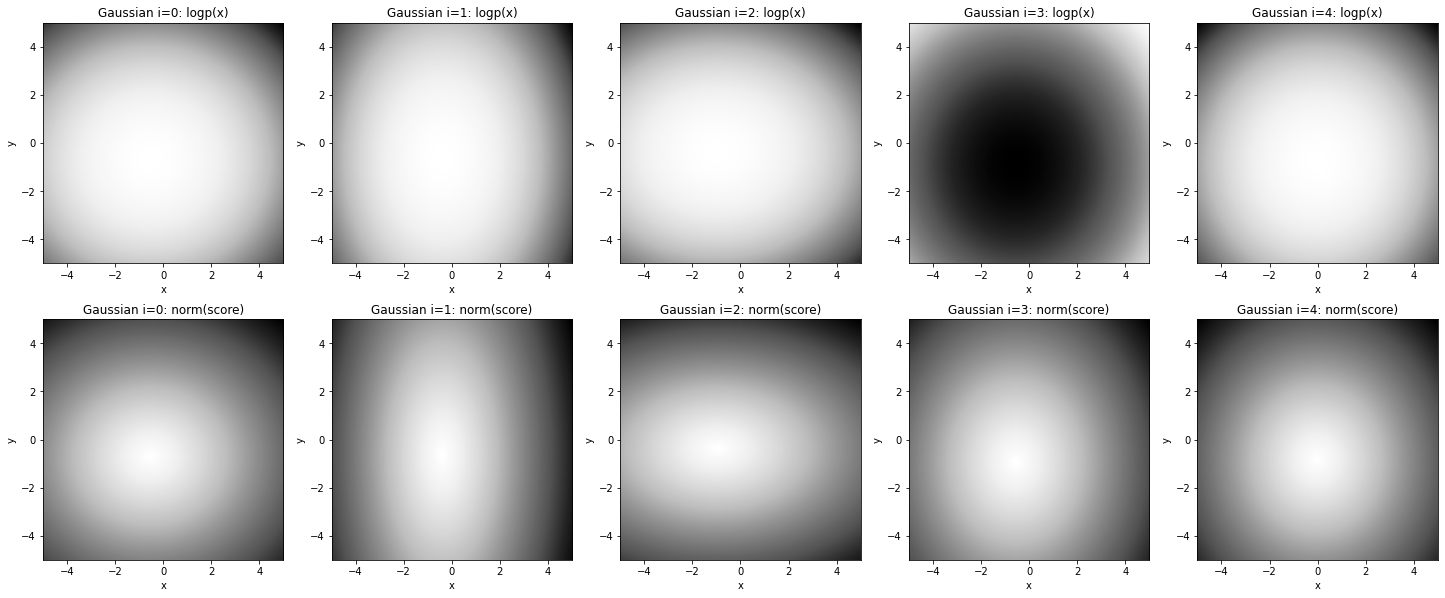

In [3]:
num_gaussians = 5
num_dimensions = 2

N = 101
M = 101
x_min, x_max = -5, 5
y_min, y_max = -5, 5
x_ticks = np.linspace(x_min, x_max, N)
y_ticks = np.linspace(y_min, y_max, M)
xx, yy = np.meshgrid(x_ticks, y_ticks)
x = np.stack((xx, yy)).reshape(2, N * M).T

fig, ax = plt.subplots(2, num_gaussians)
fig.set_figwidth(5 * num_gaussians)
fig.set_figheight(10)

for i in range(num_gaussians):
    gaussian = Gaussian(
        mu=np.random.rand(
            num_dimensions,
        ),
        covariance=np.diag(np.random.rand(num_dimensions)),
    )
    ax[0][i].imshow(
        np.flip(vmap(gaussian.log_p)(x).reshape(xx.shape), axis=1),
        cmap="Greys",
        extent=[x_min, x_max, y_min, y_max],
    )
    ax[0][i].set_xlabel("x")
    ax[0][i].set_ylabel("y")
    ax[0][i].set_title(f"Gaussian {i=}: logp(x)")

    ax[1][i].imshow(
        np.flip(
            np.linalg.norm(vmap(gaussian.score)(x), axis=1).reshape(xx.shape), axis=1
        ),
        cmap="Greys",
        extent=[x_min, x_max, y_min, y_max],
    )
    ax[1][i].set_xlabel("x")
    ax[1][i].set_ylabel("y")
    ax[1][i].set_title(f"Gaussian {i=}: norm(score)")

# Fisher Divergence

The score can be viewed as a "feature" of the original distribution, or a unique mapping like the kernels of MMD and KSD which are characterstic (captures all information about the distribution $\mathbb{P}$). As such, if we compare the scores of two distributions, we can define an measure of discrepancy between the two distributions. This is the formulation of the Fisher Divergence:

$$J = \frac{1}{2}\mathbb{E}_{x\sim\mathbb{Q}}[||\psi_p(x; \theta)-\psi_q(x)||^2]$$

the expectation of the squared distance between $\psi_p(x; \theta)$, the known distribution score function and $\psi_q(x)$, the observed data score function with resepect to $q(x)$.

This can be rewritten as:

$$J = \frac{1}{2}\int_{x \in \mathbb{R}^d}q(x) || \psi_p(x; \theta)-\psi_q(x)||^2 dx$$

We can see that we only have samples from $q(x)$, approximating the normalising constant of this function is intractable.

However, assuming the condiitons that:

- $q(x)$ is differentiable
- $\mathbb{E}_{x\sim\mathbb{Q}}[||\psi_p(x; \theta)||^2]$ and $\mathbb{E}_{x\sim\mathbb{Q}}[||\psi_q(x)||^2]$ are finite for any $\theta$
- $q(x)\psi_p(x; \theta) \rightarrow 0$ $\forall \theta$ when $||x|| \rightarrow \infty$

It can be shown that:

$$J = \int_{x \in \mathbb{R}^d}q(x) \sum_{i=1}^{n}[ \partial_i \psi_{p_i}(x; \theta)+\frac{1}{2}\psi_{p_i}(x, \theta)^2] dx + const.$$

where the constant does not depend on $\theta$ and

$$\partial_i \psi_{p_i}(x; \theta) = \frac{\partial^2 \log \tilde{p}(x; \theta)}{\partial x_i^2}$$

The numerical estimate for $J$:

$$\tilde{J} = \frac{1}{n} \sum_i^n \sum_j^d [\partial_j \psi_{p_j}(x_i; \theta)+\frac{1}{2}\psi_{p_j}(x_i, \theta)^2] + const.$$

where $n$ is the number of observed data points and $d$ is the dimensionality of the data.

We can visualise the Fisher Divergence for a number of Gaussians with each of their covariance scaled differently.

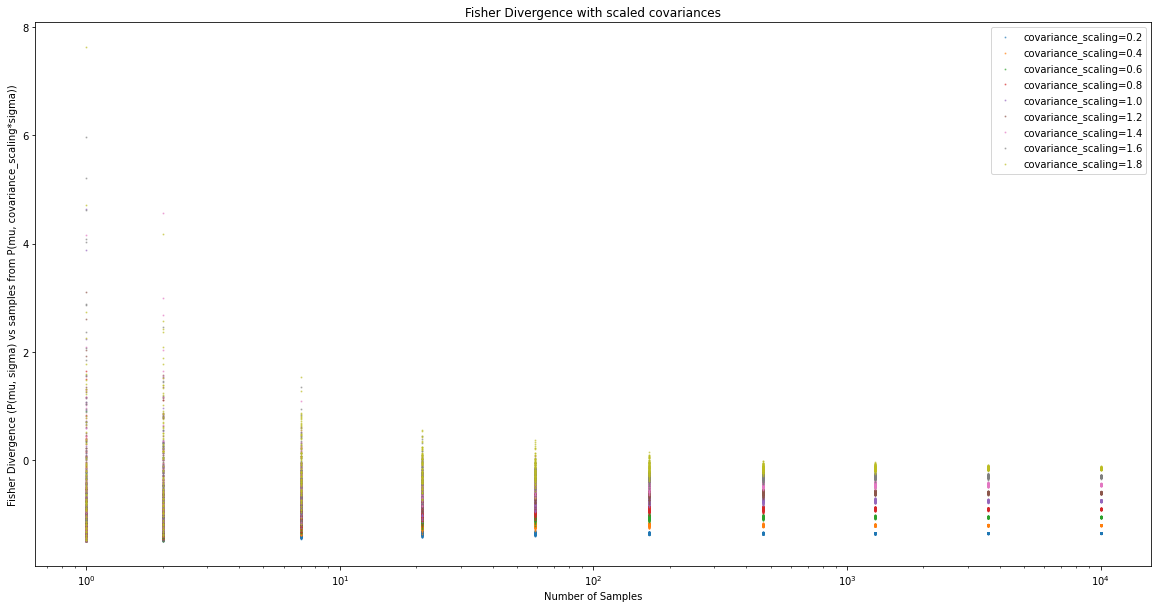

In [4]:
mu = np.array([10, 10]).reshape(
    -1,
)
covariance = np.array(
    [
        [1, 0],
        [0, 2],
    ]
)
p_base = Gaussian(mu, covariance)
covariance_scalings = np.round(np.arange(0.2, 2, 0.2), 3)
ps = [
    Gaussian(mu, covariance_scaling * covariance)
    for covariance_scaling in covariance_scalings
]

n_trials = 100
n_samples = np.logspace(0, 4, 10).astype(int)
p_samples = []
for p in ps:
    p_samples.append([p.sample((n_trials, n_sample)) for n_sample in n_samples])

fisher_vals_p = np.zeros((len(covariance_scalings), n_trials, len(n_samples)))

fisher_divergence = FisherDivergence(p=p_base)


for i in range(len(n_samples)):
    for j in range(len(ps)):
        fisher_vals_p[j, :, i] = vmap(
            lambda sample_i: fisher_divergence.compute(sample_i)
        )(p_samples[j][i])

fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(10)
ax = fig.add_subplot(1, 1, 1)
for i, covariance_scaling in enumerate(covariance_scalings):
    plt.scatter(
        np.repeat(n_samples, n_trials).reshape(-1, n_trials).T.flatten(),
        fisher_vals_p[i, :, :].flatten(),
        s=1,
        alpha=5e-1,
        label=f"{covariance_scaling=}",
    )
ax.set_xscale("log")
ax.set_title("Fisher Divergence with scaled covariances")
ax.set_xlabel("Number of Samples")
ax.set_ylabel(
    "Fisher Divergence (P(mu, sigma) vs samples from P(mu, covariance_scaling*sigma))"
)
plt.legend()
plt.show()

Here we can see the importance of having sufficient samples from our distributions to be able to visualise that the Fisher Divergence for the distributions form distinct clusters.

what is the role of the kernel in KSD vs fisher which just uses gradients of p